In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
from mpl_toolkits.mplot3d import Axes3D
import itertools
%matplotlib notebook

# Fonction Affines

Une fonction affine est une fonction de la forme:
\begin{align}
f(x)=ax+b
\end{align}

Supposons que nous étudions une propriété physique $y$ qui dépend linéairement d'une autre propriété $x$. Par exemple, $x$ pourrait être la concentration de nanotubes de carbonne dans un alliage métalique et $y$ la solidité de l'alliage.

$x$ est une quantité que nous pouvons choisir, et $y$ est une quantité que nous pouvons mesurer ou simuler. Les constantes $a$ et $b$ sont des paramètres du modèle que nous ne connaisons pas à priori car le systême est trop compliqué pour les déduire. Si nous avons assez de données $x$ et $y$, nous pouvons les apprendre avec des algorithmes. 

La fonction ci-dessous génére un nombre aléatoire $a\in [low;high]$, qui fera office de paramètre du modèle inconnu à priori.

In [2]:
def rand_in(low,high):
    return (high-low)*np.random.random()+low

Définir un vecteur $x$ contenant une dizaine de valeurs aléatoire dans l'interval $[0;1]$, une fonction affine avec $b=0$ et $a \in [1;5]$ généré aléatoirement.
Calculer $y=f(x)$ et tracer les points (x,y) avec la fonction plt.scatter. 

<IPython.core.display.Javascript object>


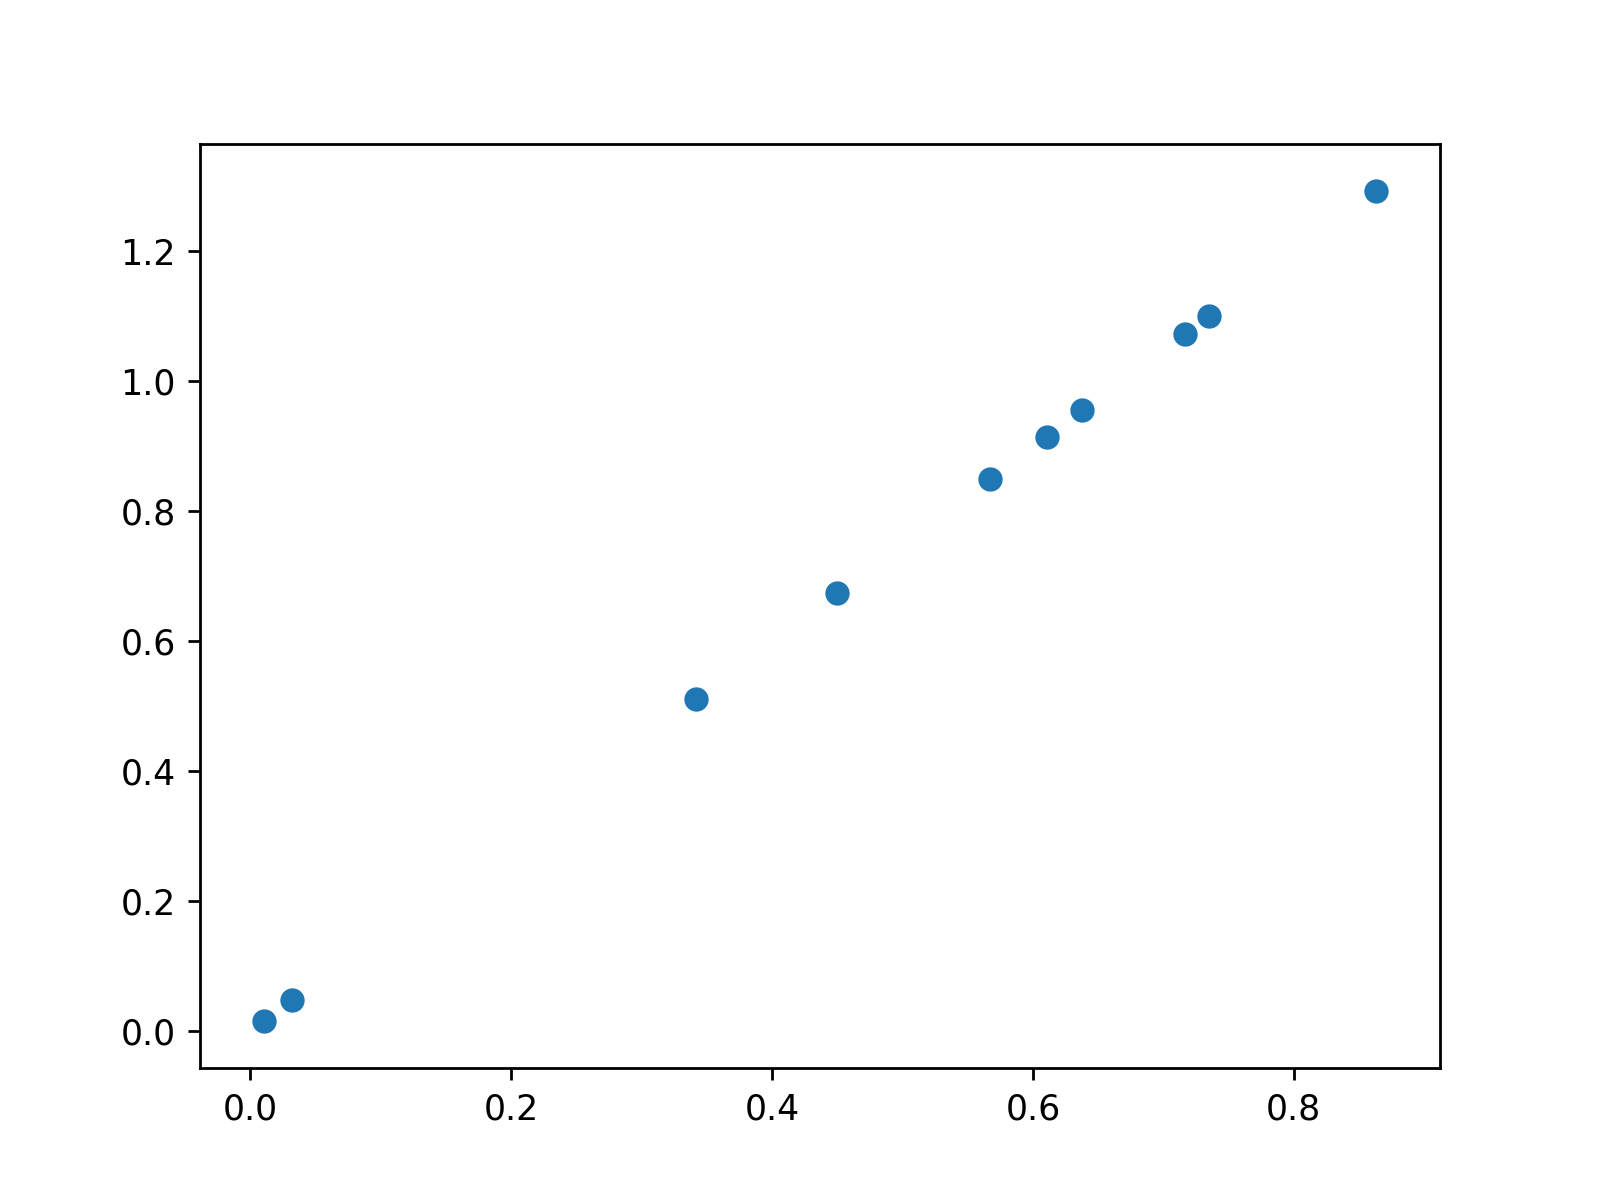

In [3]:
a=rand_in(5,1)
x=np.random.random(10)
y=a*x

#plot
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(x,y)
plt.show()

Retrouver la valeur de $a$ à partir des valeurs de $x$ et $y$ (sans faire "print(a)"!!).
Pour vérifier, tracer la ligne représentant la fonction affine $f(x)=ax$ avec plt.plot, en plus des points (x,y).

<IPython.core.display.Javascript object>


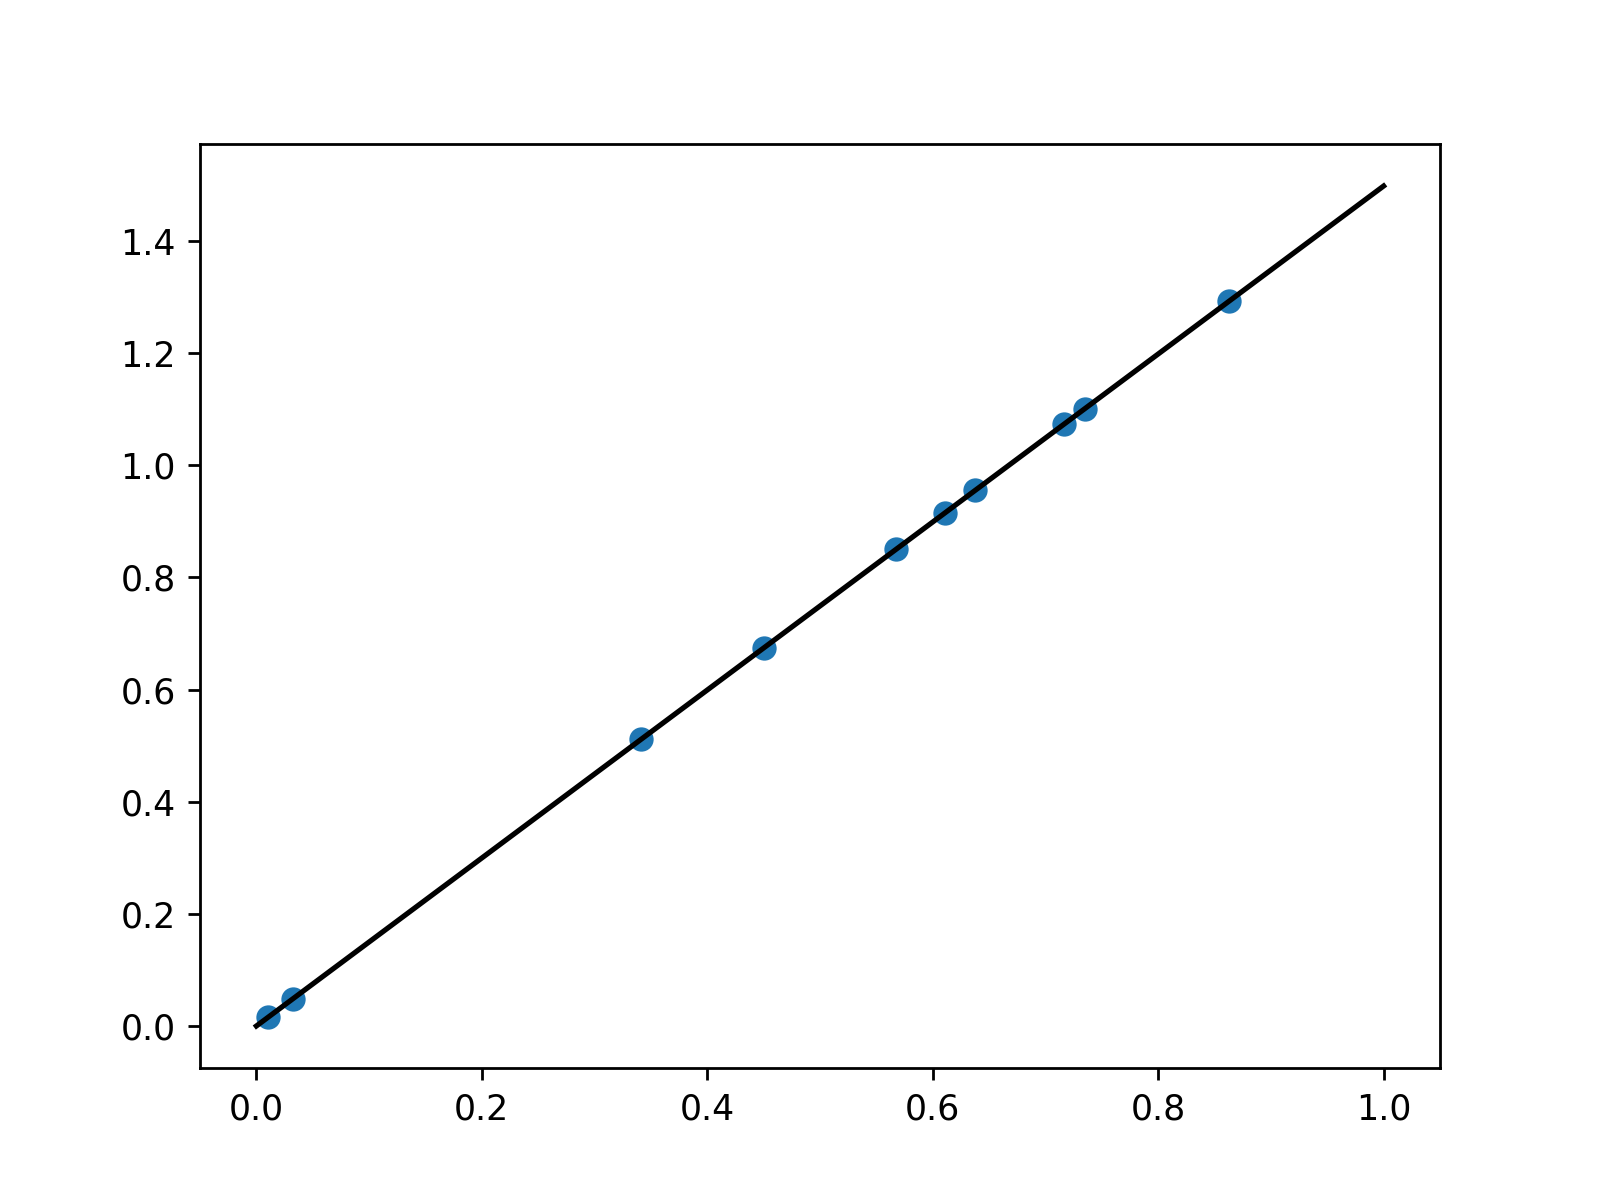

In [4]:
pente=(y[0]/x[0])
xx=np.linspace(0,1,10)
yy=pente*xx

#plot
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(xx,yy, color='k')
ax.scatter(x,y)
plt.show()

# Régression linéaire

En pratique, les choses ne collent pas aussi bien... $f$ ne représente pas parfaitement la réalité, c'est un modèle. D'autres facteurs peuvent affecter les valeurs de $y$. Par exemple, pour une même concentration de nanotubes de carbon, leur disposition peut varier suivant les détails de la préparation de l'alliage. Ceci ajoute de bruit aux données.

Ci-dessous, on ajoute artifiellement du bruit aux données: On génere une autre pente  aa , des points x aléatoires, et des valeurs  y=ax+sy=ax+s  ou s est un nombre aléatoire généré grace à une distribution normale centrée en  00  et de variance  0.20.2  (différent pour chaque valeur de x).

<IPython.core.display.Javascript object>


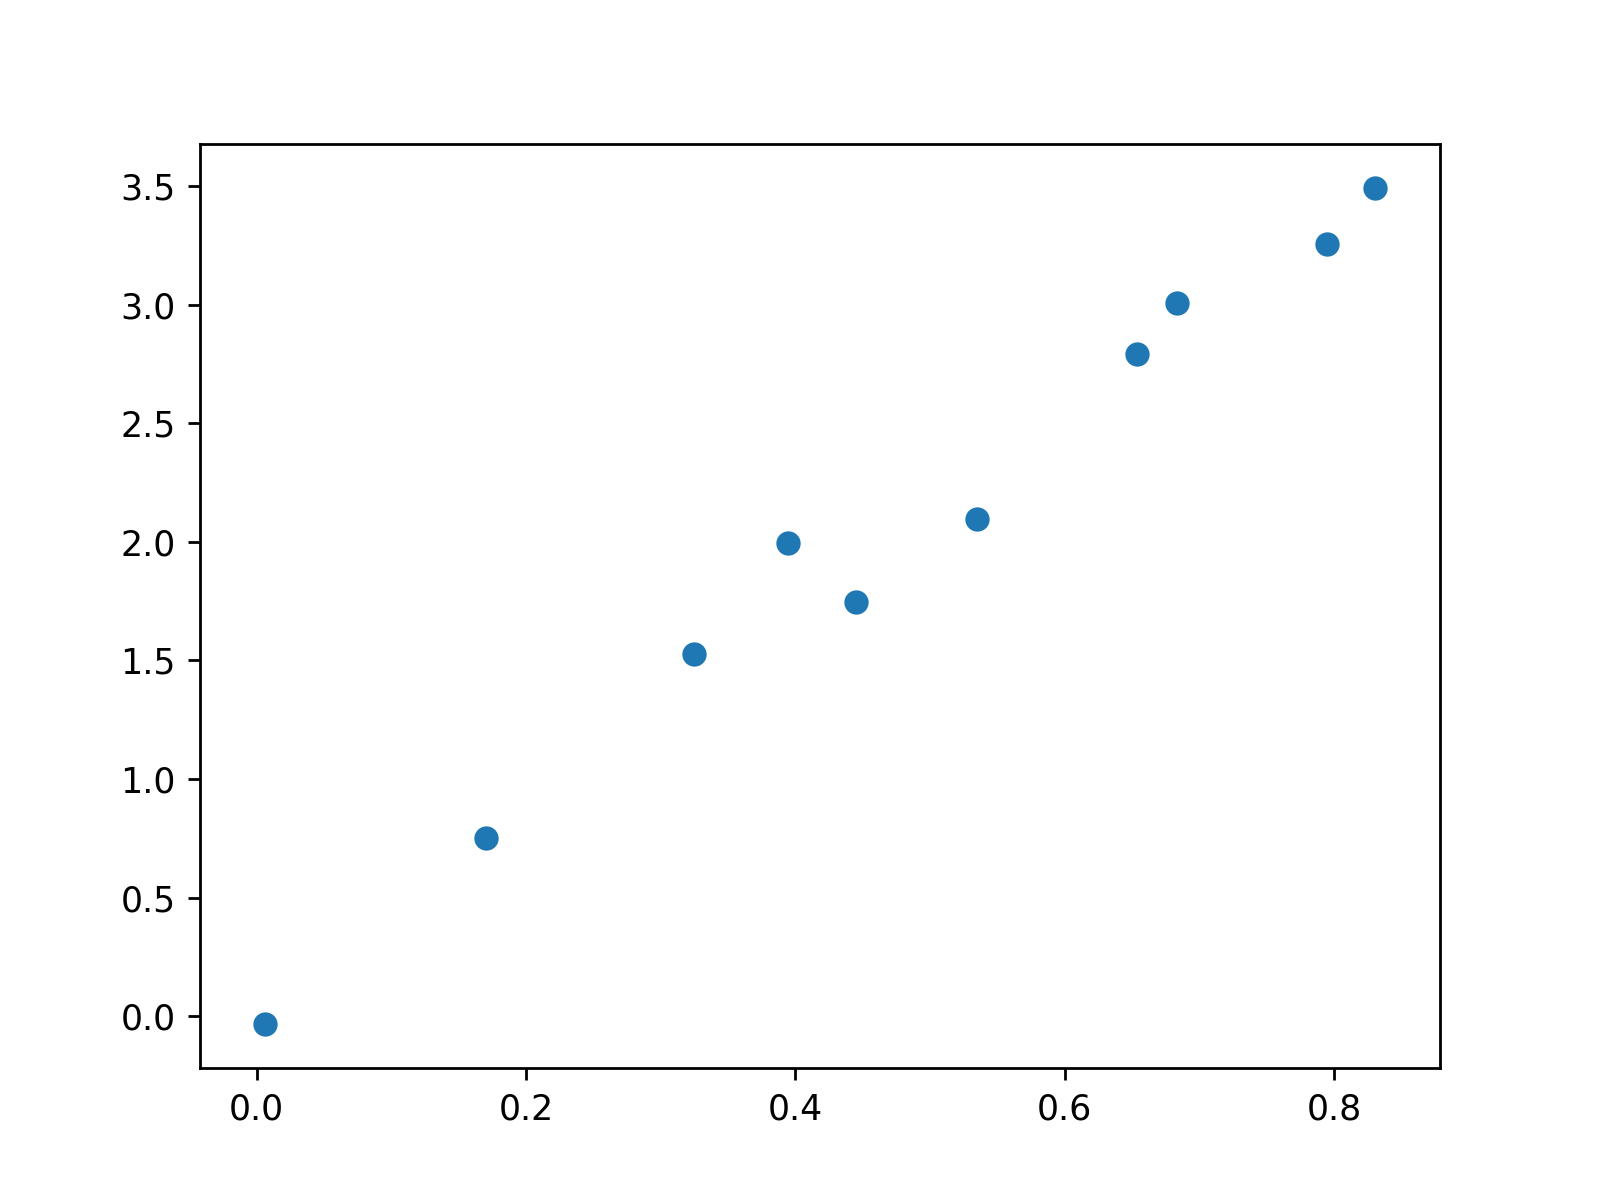

In [5]:
a=rand_in(1,5)
x=np.random.random(10)
y=a*x+np.array([np.random.normal(scale=0.2) for i in range(len(x))])

#
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(x,y)
plt.show()

La cellule ci-dessous trace une fonction affine dont la pente est un nombre entier $a$ réglable. Faire glisser la barre ci-dessous pour changer la pente de la droite tracée et estimer la nouvelle valeur de $a$.

In [6]:
## here they can use the slider to change the slope of the line until it fits the points best
@interact(a=2)
def plot_line(a):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.scatter(x,y)
    xx=np.linspace(0,1,3)
    ax.plot(xx,a*xx)
    plt.show()
    return

A Jupyter Widget

Ici, nous avons effectuer (à l'oeil) une régression linéaire. On a estimé le paramètre du modèle qui reproduit au mieux les données, c'est à dire qui minimise la distance entre les prédictions $ax$ et les données $y$. 

On va maintenant rendre cette procédure plus systématique, en commençant par définir la distance entre prédictions et données comme:
\begin{equation}
S(a)=\sum_i (y_i-ax_i)^2 
\end{equation}
Pourquoi utilise-t-on la différence au carré?

Écrire une fonction "cost" qui calcule la quantité $S(a)$, en comparant une fonction affine de pente a et les mesures $y$.
Tracer la courbe correspondant à $S(a)$ pour $a \in [1;5]$

<IPython.core.display.Javascript object>


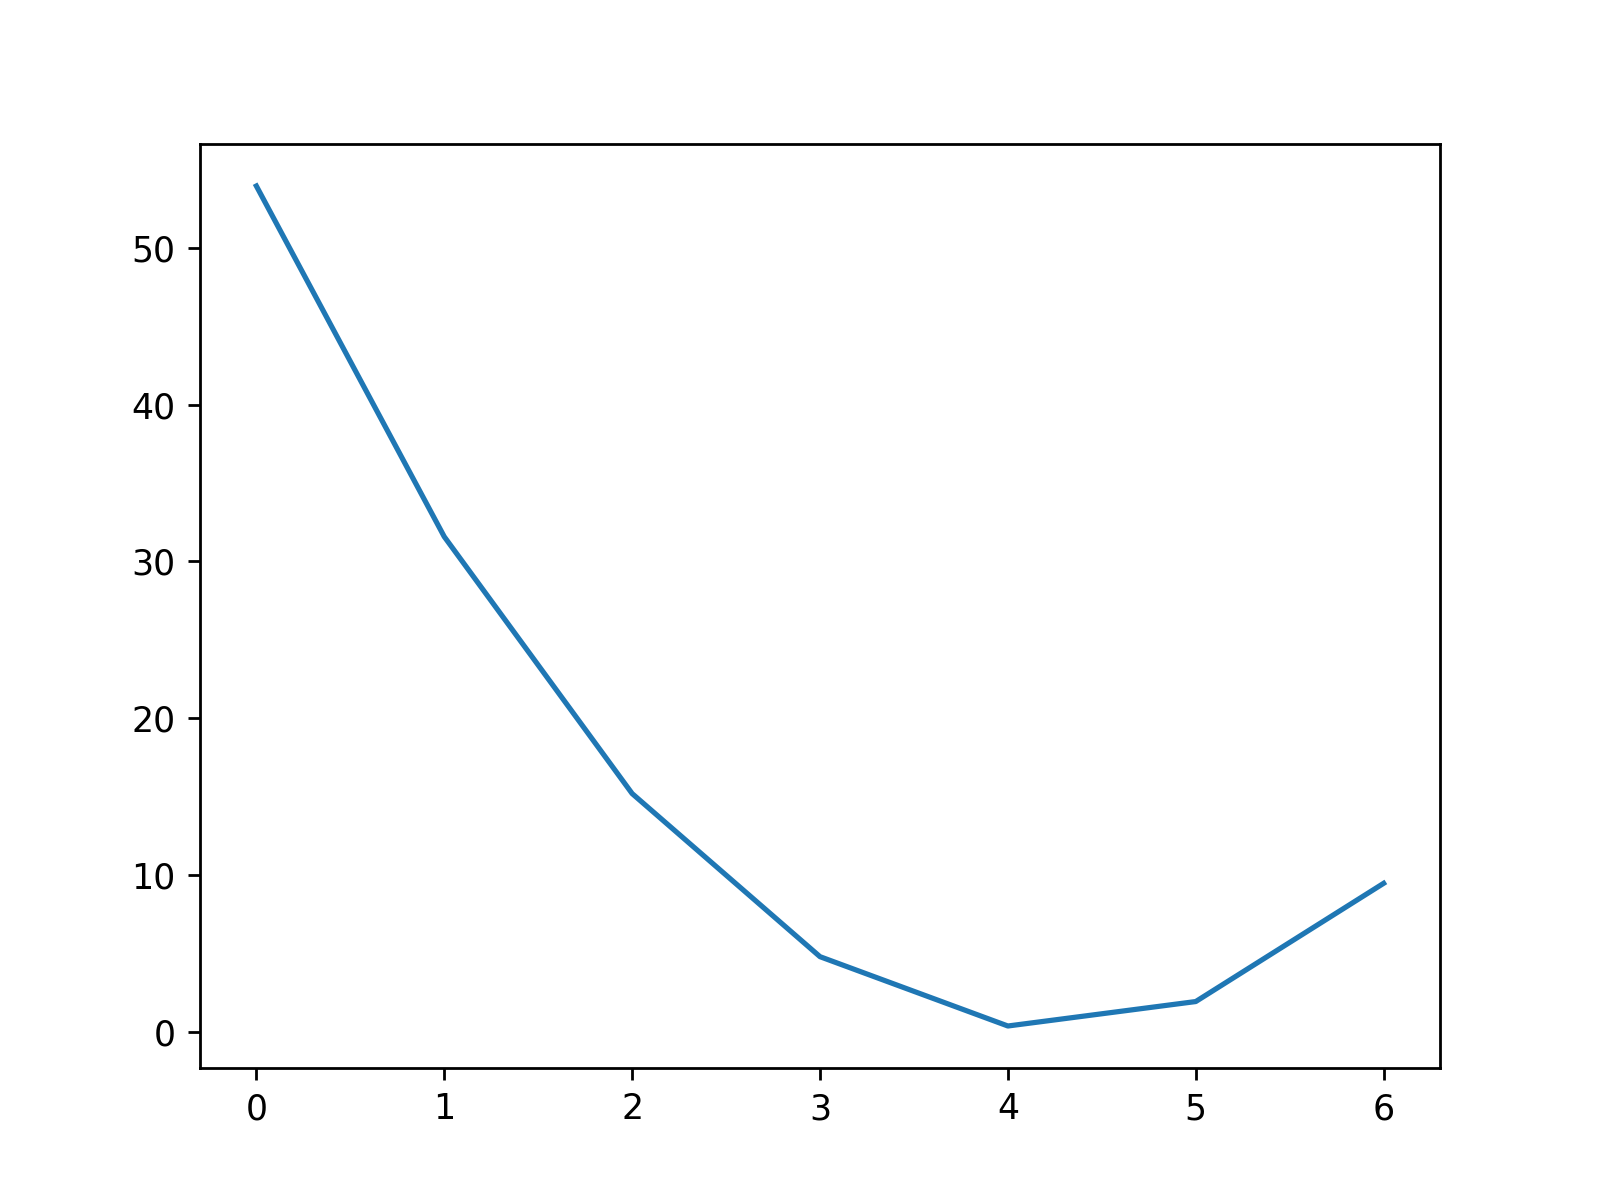

In [7]:
def cost(a,x, y):
    yn=a*x
    return np.sum((y-yn)**2)

# plot
pentes=[0,1, 2, 3, 4, 5, 6]
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(pentes, [cost(p,x,y ) for p in pentes])
plt.show()

Nous devons maintenant miniser $S(a)$, c'est-à-dire trouver la pente $a$ qui donne la plut petite erreur. 
Écrire une fonction qui, à partir d'une list de pentes à essayer et des points $x$ et $y$ , trouve la meilleures pente dans la liste, c'est à dire celle qui donne le plus petit coût.

In [8]:
def best_slope(a_list,x,y):
    return min(a_list, key=lambda z: cost(z,x,y))

#test
print(best_slope([0.,1.0,2.0,3.0,4.0],x,y),best_slope([2.8,3.0,3.2, 3.3, 3.4],x,y))

4.0 3.4


Nous allons effectuer une régression linéaire simplifiée comme suit:
- Partir d'un interval donné.
- Prendre $N$ valeur de pente equidistantes dans cette interval.
- Trouver la meilleure en utilisant la fonction ci-dessus.
- Recommencer en prenant comme nouvel interval celui défini par les 2 valeurs de pente autour de la meilleure 

L'algorithme s'arretera lorsque on sait que la meilleure pente se trouve dans un interval plus petit qu'un certain palier.
Ecrire les fonctions nécessaires. Ajouter un compteur qui copmte le nombre total de pentes essayées, ce qui nous donnera une idée du coup de notre algorithme.
Est-t-il une bonne idée de prendre $N$ grand? 

In [9]:
# fonction pour générer N pentes dans un interval donné:
# inputs:  rng=[low,high], N
# outputs: alist=[a1, a2, ..., aN] compris dans l'interval [low,high] et régulièrement espacés
def a_list(rng, N):
    return np.linspace(rng[0],rng[1],N)

# fonction pour trouver la résolution associée à un certain interval:
# inputs:  rng=[low,high], N
# outputs: différence entre 2 pentes consécutives
def Da(rng, N):
    return abs(rng[1]-rng[0])/N

# régression linéaire: 
# inputs: données x et y, un palier thr, un interval initial init_rng, 
#         le nombre de pentes à prendre dans chaque interval N
# outputs: la pente trouvée ba, le résultat du compteur count 
def simple_lreg(x,y,thr, init_rng, N):
    # initialisation
    rng=init_rng
    count=0
    # Boucle while, qui s'arrête lorsque la résolution des pentes est plus petite que thr.
    while Da(rng,N) > thr:
        # on génére la liste des pentes à essayer
        alist= a_list(rng, N)
        # on les essaye et on trouve la meilleure
        ba=best_slope(alist,x,y)
        # compteur
        count+=len(alist)
        # on met à jour l'interval en le rétrécissant autour de la meilleure pente.
        rng=[ba-Da(rng,N),ba+Da(rng,N)]
    return ba, count

In [10]:
simple_lreg(x,y,0.0001,[1.,5.],7)

(4.2391322209850193, 49)

In [11]:
simple_lreg(x,y,0.0001,[1.,5.],20)

(4.2392631578947366, 80)

# variable multi-dimensionelle

Supposons maintenant que nous avons 2 variables connues $x_{1,i}, x_{2,i}$ et toujours une seule variable à prédire $y_i$. On suppose toujours que l'on peut approximativement représenter leur relation linéairement, en faisant la somme des 2 fonctions affines : 
\begin{align}
y_i&\approx a_1 x_{1,i}+a_2 x_{2,i} \\
\end{align}
La distance des prédictions aux données est défini de la même manière, mais elle dépend cette fois de 2 paramètres:
\begin{align}
S(a_1, a_2)&=\sum_i (y_i-(a_1 x_{1,i}+a_2 x_{2,i}))^2
\end{align}
Pour effectuer une régression linéaire et trouver les meilleures valeurs de $a_1$ et $a_2$, on doit toujours minimiser la fonction $S(a_1, a_1)$. 

Ecrire une fonction cost2d qui calcule $S(a_1, a_1)$ pour une fonction $f$ à 2 variables.

In [12]:
def cost2d(a,x, y):
    yn=a[0]*x[0,:]+a[1]*x[1,:]
    return np.sum((y-yn)**2)

Générer 2 pentes aléatoires $a_1$ et $a_2$, et 100 valeurs de $x_1$ et $x_2$ aléatoires entre $0$ et $1$, et les valeurs de $y$ correspondantes, avec une erreur gaussienne de variance 0.4. 

Tracer ensuite, dans un plot 3D, la surface associée à la fonction $S(a_1, a_2)$ pour des valeurs de $a_1$ et $a_2$ entre $1$ et $5$.

<IPython.core.display.Javascript object>


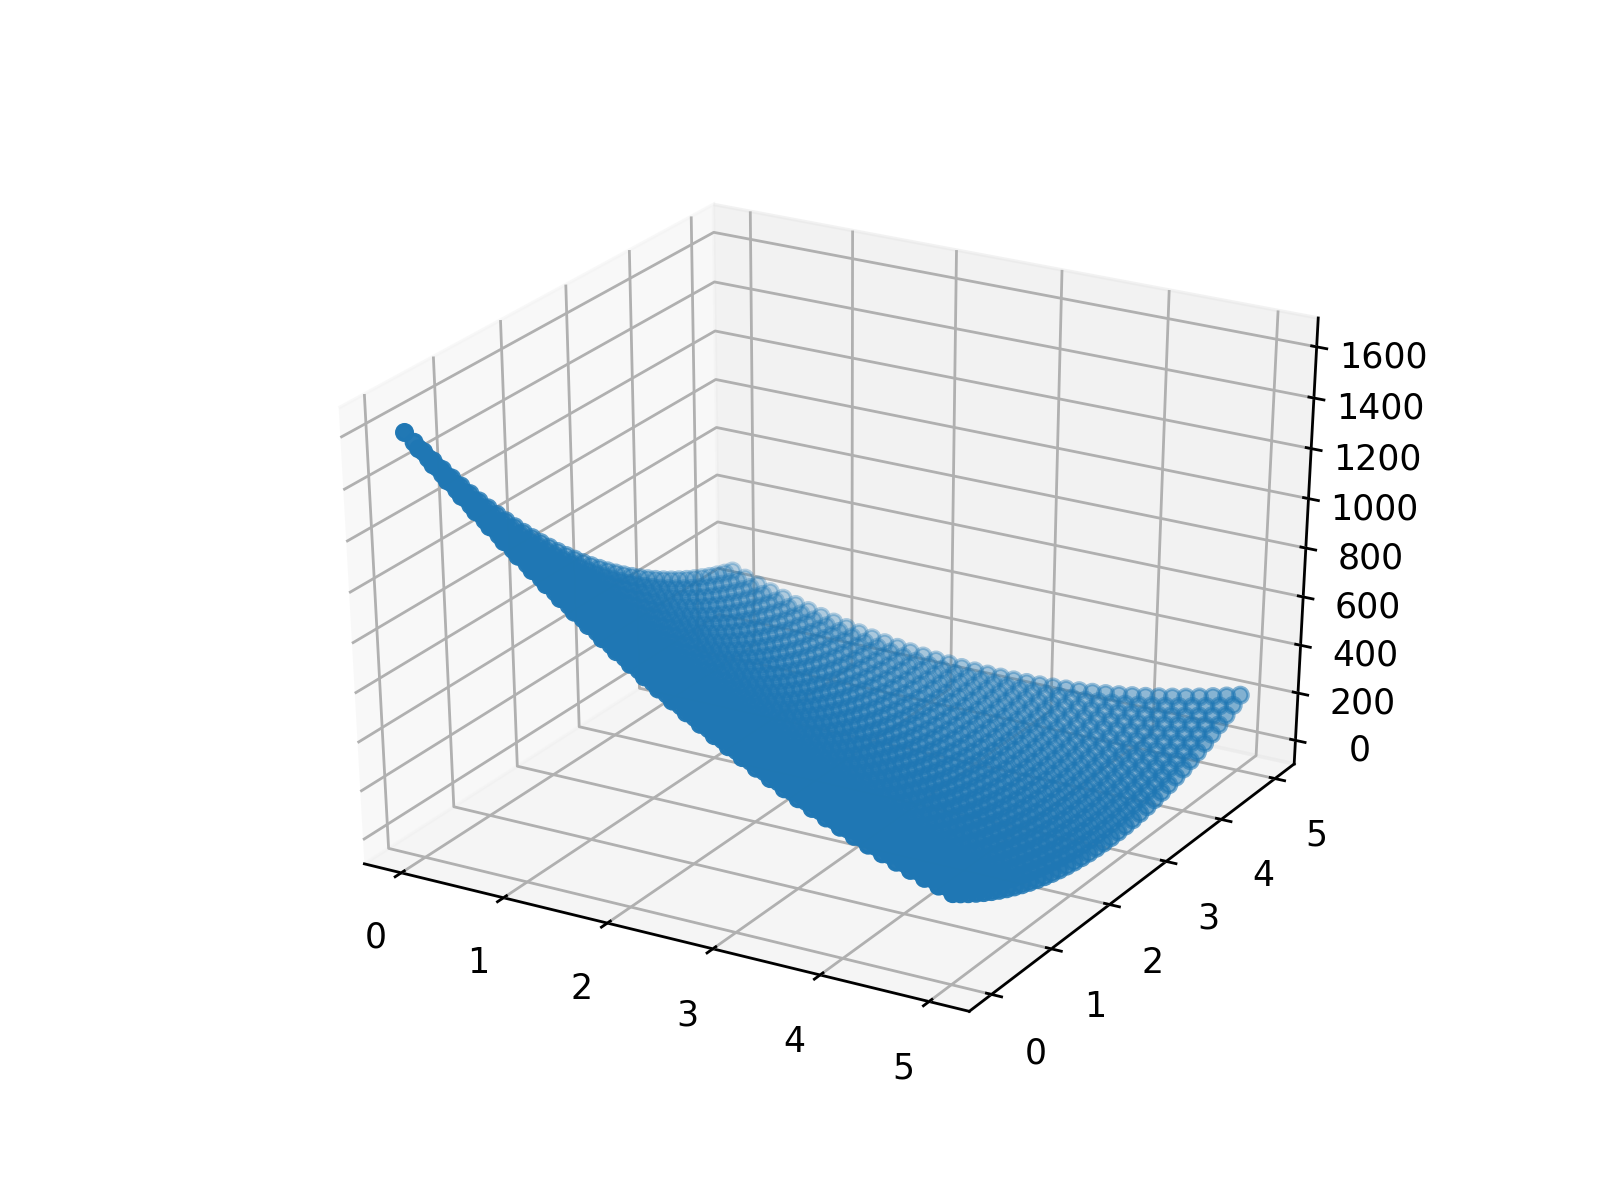

In [18]:
Nx=100
a=np.array([rand_in(1,5), rand_in(1,5)])
x=np.array([np.random.random(Nx),np.random.random(Nx)])
y=a[0]*x[0,:]+a[1]*x[1,:]+2*np.array([np.random.normal(scale=0.2) for i in range(Nx)])

pentes=np.linspace(0,5,40)
data=np.array([[p1,p2,cost2d([p1,p2],x,y)] for p1,p2 in itertools.product(pentes, pentes)] )

# plot
fig=plt.figure()
ax=plt.subplot(111,projection='3d')
ax.scatter(data[:,0],data[:,1],data[:,2])
plt.show()

Dans l'esprit de la regression lineaire ecrite plus haut, ecrire une version 2D

In [15]:
def best_slope2D(alist,x,y):
    a_init=np.array([0.,0.]) 
    lowestcost=cost2d(a_init,x,y)
    best=a_init
    for a1 in alist[0]:
        for a2 in alist[1]:
            c=cost2d([a1, a2], x,y)
            if c< lowestcost:
                lowestcost=c
                best=[a1,a2]
    return best
def Da2D(rng, N):
    return [abs(rng[0][1]-rng[0][0])/N,abs(rng[1][1]-rng[1][0])/N]
def simple_lreg2D(x,y,thr, init_rng, N):
    rng=init_rng
    count=0
    while max(Da2D(rng,N)) > thr:
        alist=np.array([np.linspace(rng[0][0],rng[0][1],N), np.linspace(rng[1][0],rng[1][1],N)])
        ba=best_slope2D(alist,x,y)
        count+=N**2
        D=Da2D(rng,N)
        rng=[[ba[0]-D[0],ba[0]+D[0]],[ba[1]-D[1],ba[1]+D[1]] ]
    print("after trying ",count," slopes")
    return ba, count

In [19]:
print(a)
simple_lreg2D(x,y,0.0001,[[-1,6.],[-1,6.]],7)

[ 4.56313993  2.83164936]
after trying  392  slopes


([4.6767149175371951, 2.8694520707074997], 392)

Ce que l'on a fait pour 1 puis 2 variables endogènes peut être généralisé à $N_{var}$. 
Voici une version ND de l'algorithme utilisé jusqu'a present:

In [20]:
def costNd(a,x, y):
    yn=sum(ai*xi for ai, xi in zip(a,x))
    return np.sum((y-yn)**2)

def best_slopeND(alist,x,y):
    lowestcost=costNd(alist[:,0],x,y)
    best=alist[:,0]
    for ax in itertools.product(*alist):
            c=costNd(ax, x,y)
            if c< lowestcost:
                lowestcost=c
                best=ax
    return best
def DaND(rng, N):
    return [abs(r[1]-r[0])/N for r in rng]
def simple_lregND(x,y,thr, init_rng, N):
    rng=init_rng
    count=0
    while max(DaND(rng,N)) > thr:
        alist=np.array([np.linspace(r[0],r[1],N) for r in rng])
        ba=best_slopeND(alist,x,y)
        count+=N**len(alist)
        rng=[[b-D,b+D] for b,D in zip(ba, DaND(rng,N)) ]
    print("after trying ",count," slopes")
    return ba, count

In [21]:
Nvar=5
Np=2000
A=np.array([rand_in(1,5) for i in range(Nvar)])
X=np.array([np.random.random(Np) for i in range(Nvar)]).T
Y=np.dot(X,A)+Nvar*np.array([np.random.normal(scale=0.2) for i in range(Np)])
#Afit=np.dot( np.linalg.inv(np.dot(X.T,X)) , np.dot(X.T,Y) )

In [22]:
print(A)
Adum, nslo=simple_lregND(X.T,Y,0.0001,[[1.,5.]]*Nvar,7)
Afit=np.array(Adum)
print(Afit)

[ 2.87083866  2.13693003  4.73837957  1.38320583  3.38095416]
after trying  117649  slopes
[ 2.80861716  2.12798239  4.83565804  1.25151652  3.47655314]


0.00797918375501


<IPython.core.display.Javascript object>


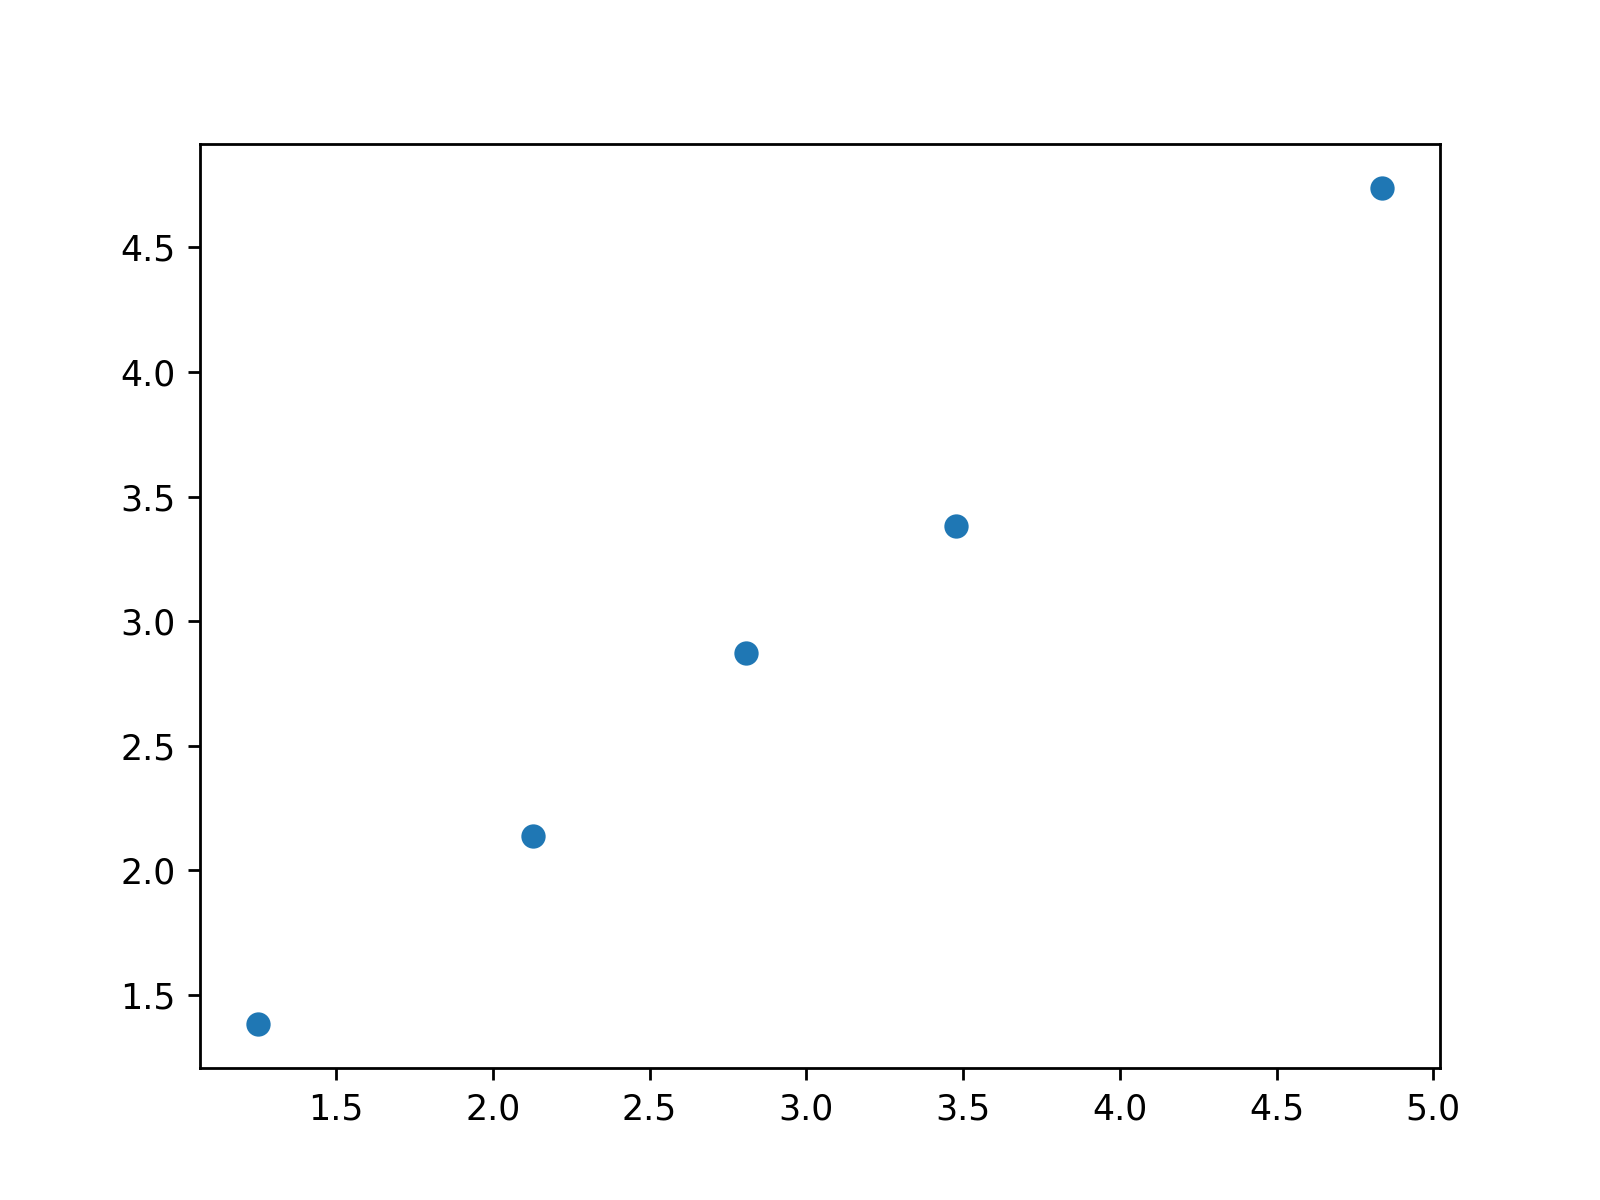

In [23]:
print(np.sum((A-Afit)**2)/Nvar)
fig=plt.figure()
ax=plt.subplot(111)
ax.scatter(Afit,A)
plt.show()

# Entrainement

Le nombre d'élements $x_i$ accroit la qualité de la régression linaire.

In [24]:
Nvar=5
A=np.array([rand_in(1,5) for i in range(Nvar)])

<IPython.core.display.Javascript object>


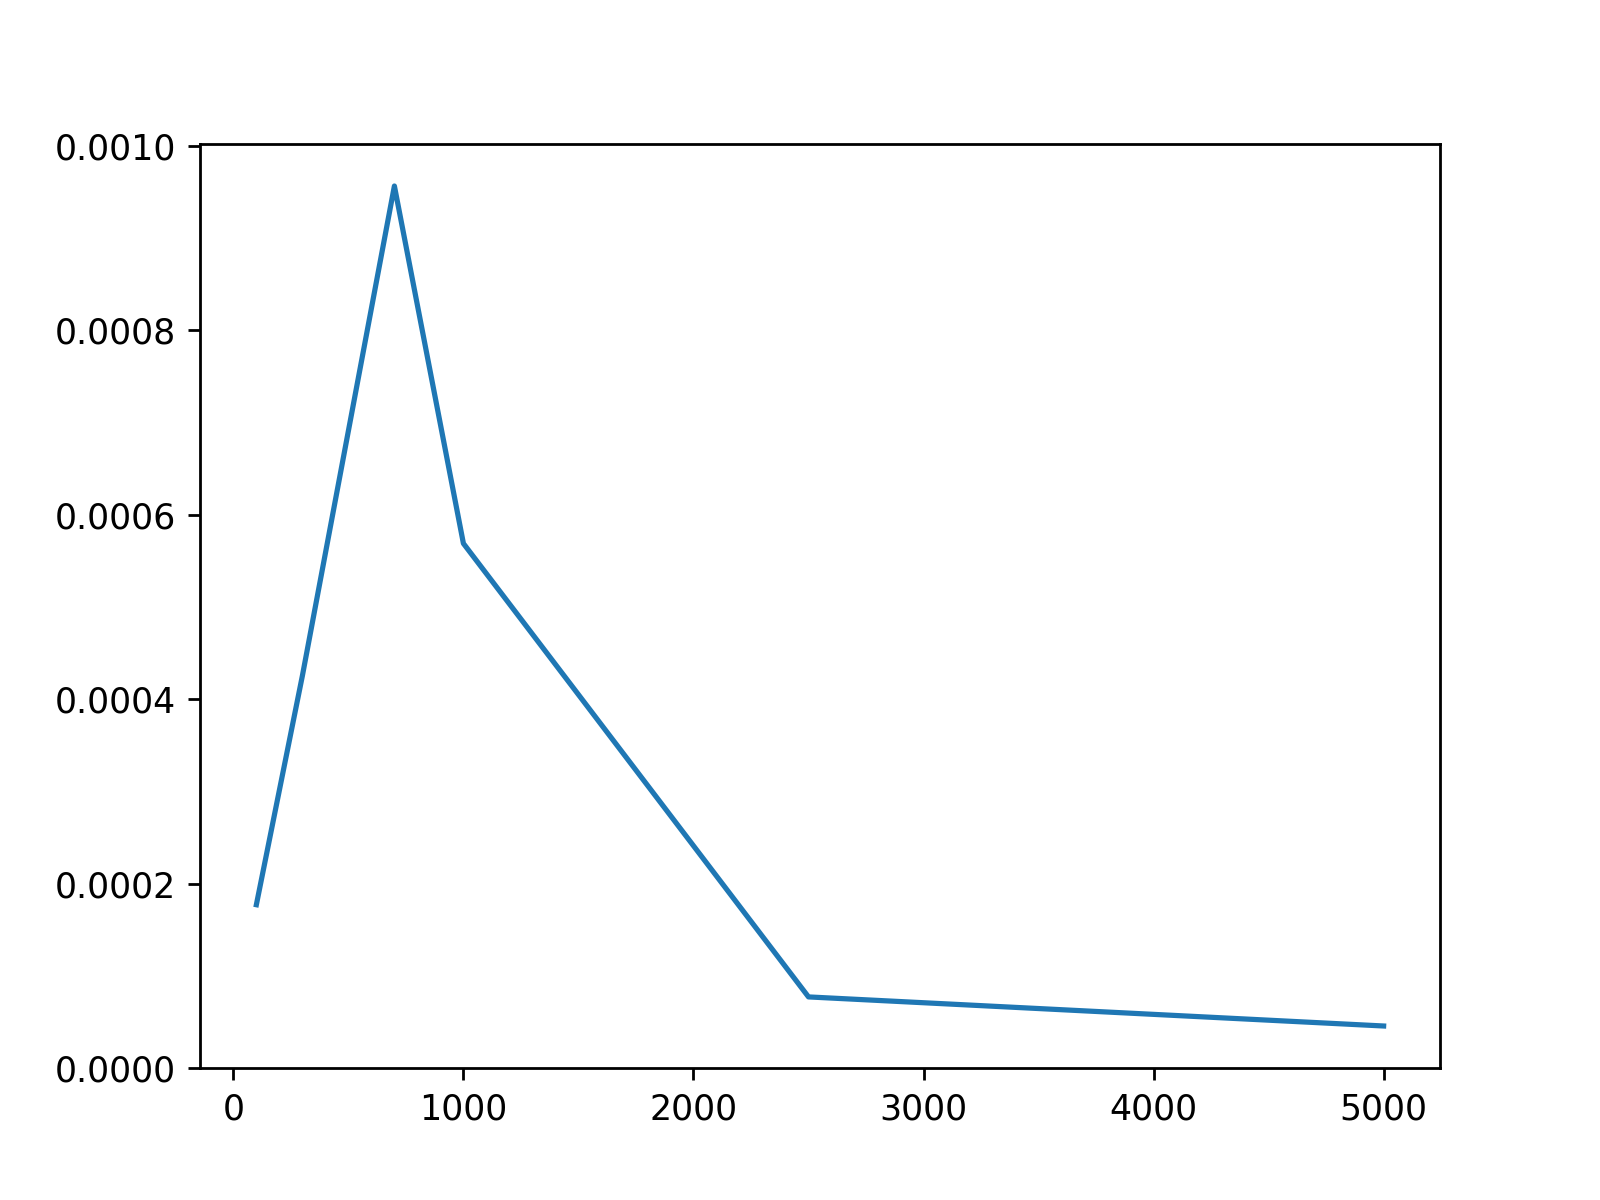

after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes


In [25]:
fig=plt.figure()
ax=plt.subplot(111)
Nps=[ 100,300,700, 1000, 2500, 5000]
errors=[]
for Np in Nps:
    X=np.array([np.random.random(Np) for i in range(Nvar)]).T
    Y=np.dot(X,A)+np.array([np.random.normal(scale=0.2) for i in range(Np)])
    Adum, nslo=simple_lregND(X.T,Y,0.0001,[[1.,5.]]*Nvar,7)
    Afit=np.array(Adum)
    #Afit=np.dot( np.linalg.inv(np.dot(X.T,X)) , np.dot(X.T,Y) )
    errors.append(np.sum((A-Afit)**2)/Nvar)
ax.plot(Nps,errors)
plt.show()

# Entrainement et test

On considère un ensenble de 5 variables $x_i$ prenant chacune 1000 valeures entre $0$ et $1$, ainsi que $1000$ valeures d'une observable $y$ qui dépend linéairement des $x_i$ avec des pentes $a_i$ entre $1$ et $5$ à estimer.

In [26]:
Np=1000
Nvar=5
A=np.array([rand_in(1,5) for i in range(Nvar)])
X=np.array([np.random.random(Np) for i in range(Nvar)]).T
Y=np.dot(X,A)+np.array([np.random.normal(loc=np.rint(2*(float(i)-Np/2)/Np),scale=1.0) for i in range(Np)])

Nous séparons l'ensemble de 1000 points de données en 2 parties: 

- 800 points de données pour entrainer notre regression linéaire
- 200 points pour la tester

Comment choisir les données d'entrainement?
Commencer par simplement sélectionner les 800 premiers points de données. Effectuer la régression et la tester en plottant les prédictions et les valeurs de $y$ pour les 200 points de test sur le même graph. 

In [27]:
Ntr=800
Xtr=X[:Ntr,:]
Ytr=Y[:Ntr]
Xte=X[Ntr:,:]
Yte=Y[Ntr:]
Adum, nslo=simple_lregND(X.T,Y,0.0001,[[1.,5.]]*Nvar,7)
Afit=np.array(Adum)
#Afit=np.dot( np.linalg.inv(np.dot(X.T,X)) , np.dot(X.T,Y) )

after trying  117649  slopes


<IPython.core.display.Javascript object>


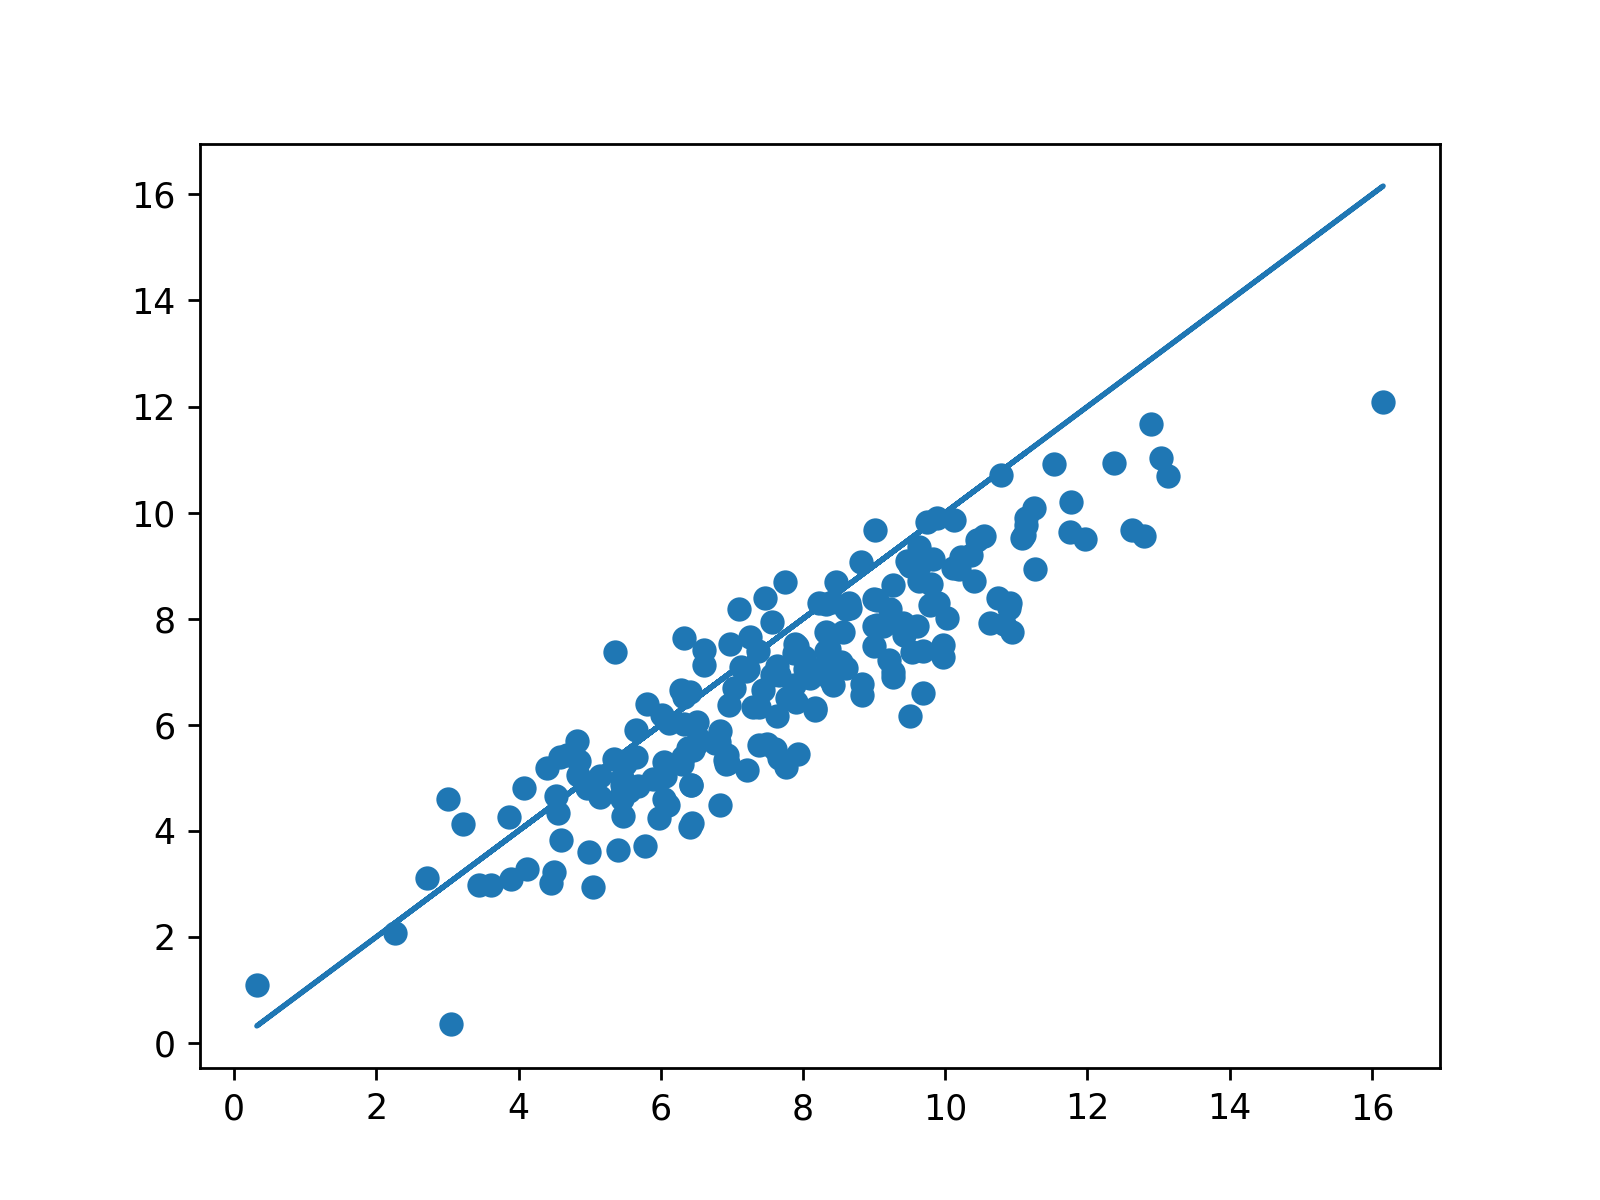

1.42210696678


In [28]:
fig=plt.figure()
ax=plt.subplot(111)
ax.scatter(Yte,np.dot(Xte,Afit))
ax.plot(Yte, Yte)
print(np.sqrt(np.sum((Yte-np.dot(Xte,Afit))**2)/len(Yte)))
plt.show()

La qualité de la régression n'est pas optimale. C'est parce que nos données incluent un léger biais, en fonction de leur position dans le vecteur. Comme nous ne prenons que le début du vecteur, la régression ne marche pas bien pour la fin. POur remédier à cela, il suffit de choisir les 800 points d'entrainement au hasard.

In [29]:
indices = np.random.permutation(Np)
training_idx, test_idx = indices[:Ntr], indices[Ntr:]
Xtr, Xte = X[training_idx,:], X[test_idx,:]
Ytr, Yte = Y[training_idx], Y[test_idx]
Adum, nslo=simple_lregND(X.T,Y,0.0001,[[1.,5.]]*Nvar,7)
Afit=np.array(Adum)
#Afit=np.dot( np.linalg.inv(np.dot(X.T,X)) , np.dot(X.T,Y) )

after trying  117649  slopes


<IPython.core.display.Javascript object>


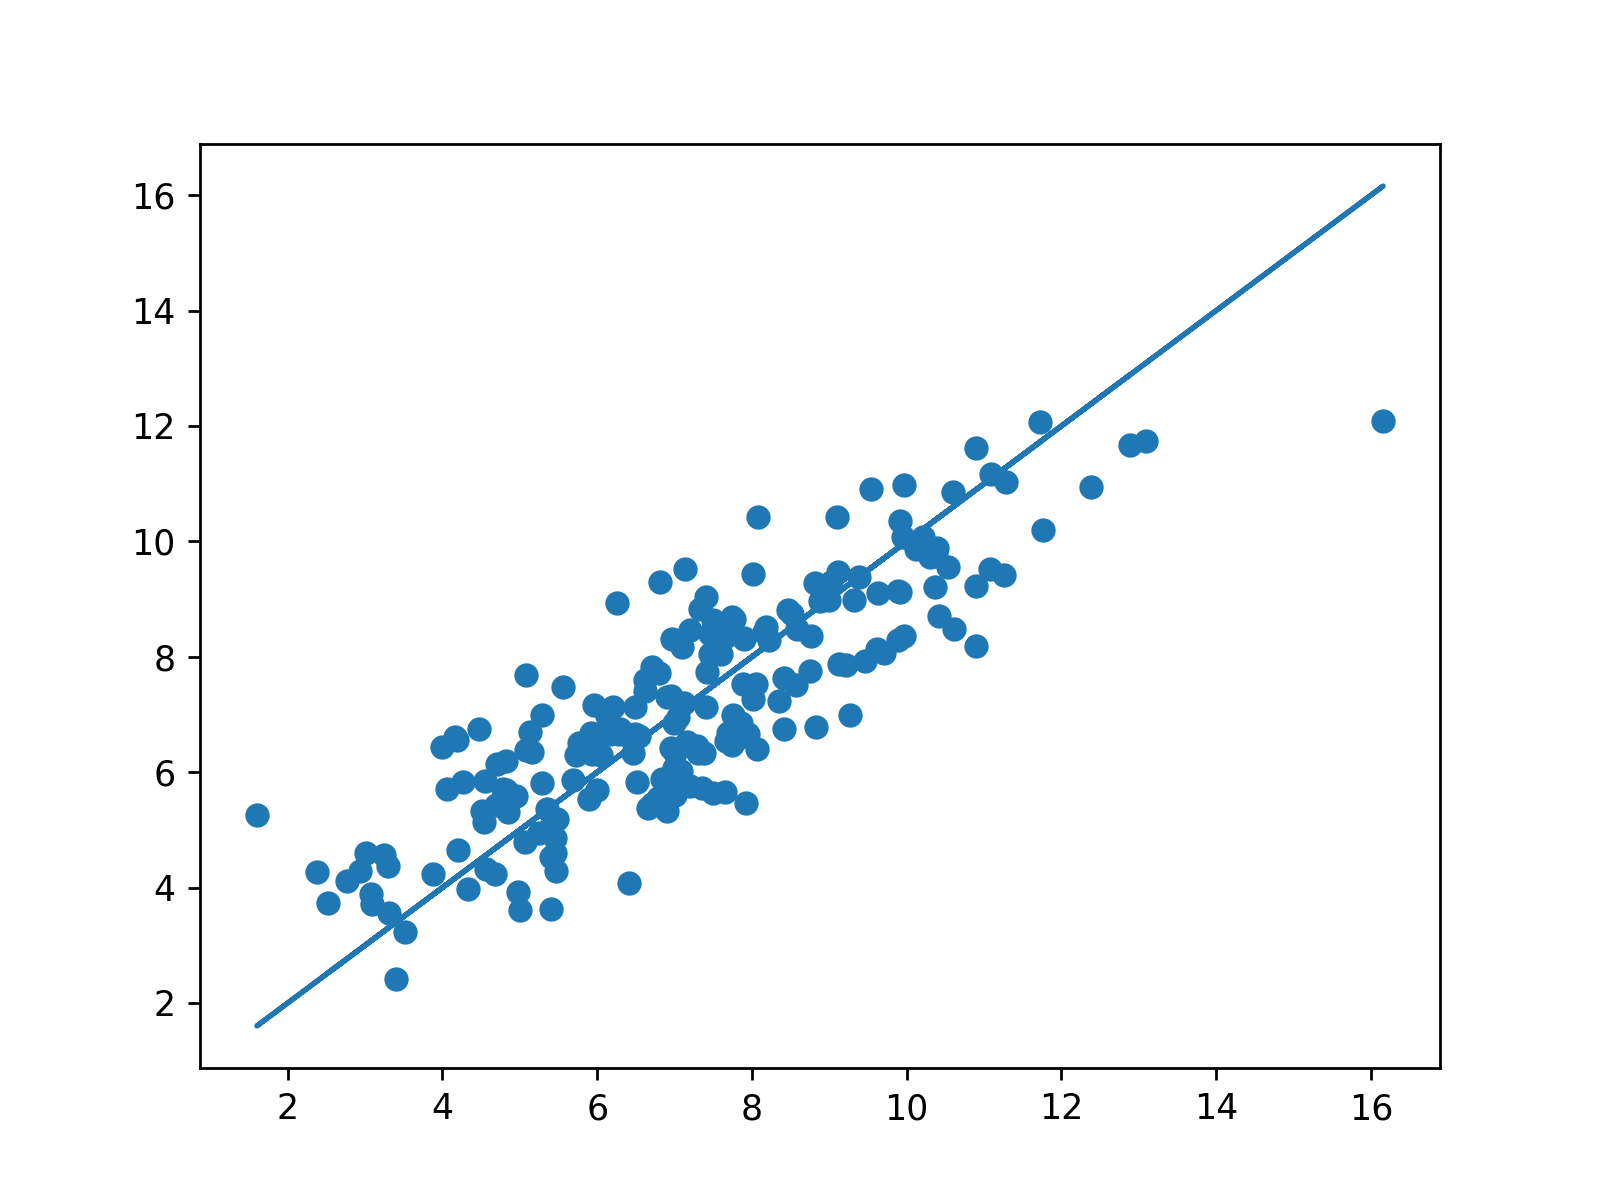

1.21585426425


In [30]:
fig=plt.figure()
ax=plt.subplot(111)
ax.scatter(Yte,np.dot(Xte,Afit))
ax.plot(Yte, Yte)
print(np.sqrt(np.sum((Yte-np.dot(Xte,Afit))**2)/len(Yte)))
plt.show()

<IPython.core.display.Javascript object>


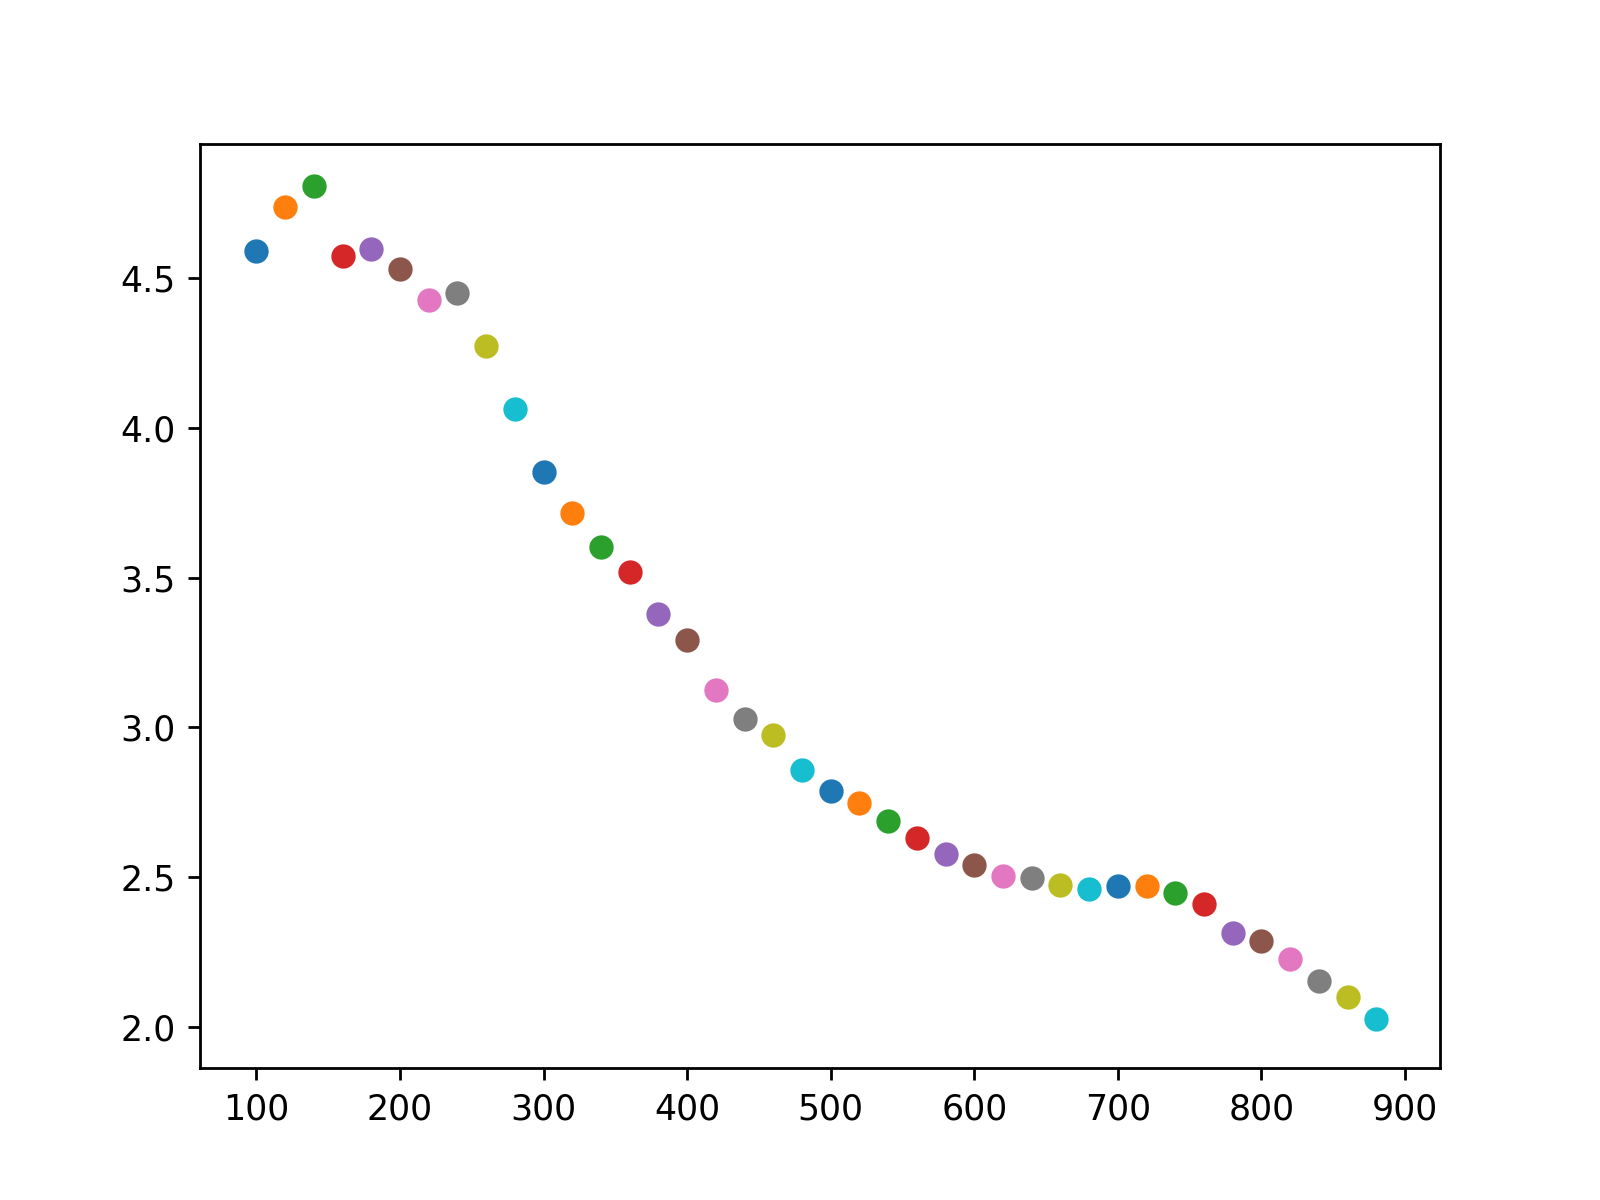

In [31]:
fig=plt.figure()
ax=plt.subplot(111)
Ntrs=np.arange(100, 900, 20)
for Ntr in Ntrs:
    Xtr=X[:Ntr,:]
    Ytr=Y[:Ntr]
    Xte=X[-100:,:]
    Yte=Y[-100:]
    Afit=np.dot( np.linalg.inv(np.dot(Xtr.T,Xtr)) , np.dot(Xtr.T,Ytr) )
    #ax.scatter(Ntr,np.sum((A-Afit)**2)/Nvar )
    ax.scatter(Ntr,np.sum((Yte-np.dot(Xte,Afit))**2)/len(Yte))
plt.show()